In [165]:
import pandas as pd
from sklearn.model_selection import train_test_split
import data_processing 
import numpy as np
from sklearn.inspection import partial_dependence

from sklearn.inspection import PartialDependenceDisplay
import shap
from sklearn.inspection import permutation_importance
import importlib
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
import models
importlib.reload(ph)
import pickle
import plot_helper as ph

In [153]:
x_train, x_test, y_train, y_test = data_processing.data_selected_features()

In [154]:
### SHAP
def get_shap_values(model, x_train, x_test):
    explainer = shap.KernelExplainer(model.predict,x_train)
    shap_values = explainer.shap_values(x_test)
    return shap_values


In [155]:
def get_random_feature(x_train, x_test, distributions, split_column= None, scaling = 0.01):
    if split_column ==  "":
        return  distributions[0], distributions[1]
    else:
        return x_train.copy()[split_column] + distributions[0] * scaling, x_test.copy()[split_column] + distributions[1] * scaling

        

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

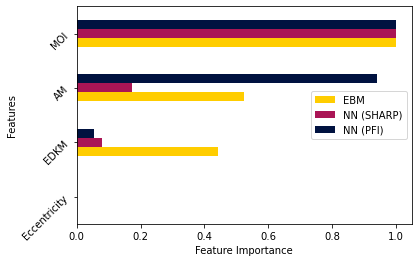

In [156]:
nn = models.nn_model()
nn.fit(x_train, y_train)
s = get_shap_values(nn, x_train, x_test.iloc[0:100]).mean(axis=0)
sharp_base = data_processing.normalize_data(abs(s))
pfi_base = data_processing.normalize_data(permutation_importance(nn, x_test, y_test, n_repeats=10)["importances_mean"])

ebm = ExplainableBoostingClassifier().fit(x_train, y_train)
ebm_base = data_processing.normalize_data(ebm.term_importances()[0:len(x_train.columns)])


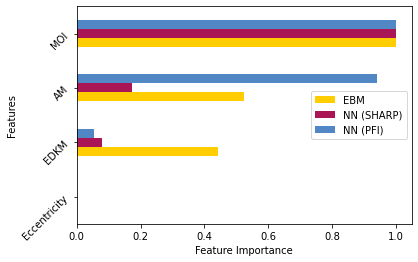

In [166]:
c = x_train.columns.tolist().copy()
c.remove("Random")
ph.plot_bar(sharp_base, ebm_base, pfi_base, c, "base")


In [157]:

# beta 
normal = (np.random.normal(0,1,  size=x_train.shape[0]), np.random.normal(0,1,  size=x_test.shape[0]))
weibull = (np.random.weibull(1.5,  size=x_train.shape[0]),np.random.weibull(1.5,  size=x_test.shape[0]))


distributions = [normal, weibull]
distributions_names = ["Normaldistribution", "Weibulldistribution"]
sharp_results = {}
sharp_results_unnormal = {}
ebm_results = {}
ebm_results_unnormal = {}
pfi_results = {}
pfi_results_unnormal = {}
split_column = ["", "MOI", "AM"]

for split in split_column:
    
    for names, dis in zip(distributions_names, distributions):
        x_train["Random"] , x_test["Random"] = get_random_feature(x_train, x_test, dis, split_column=split)

        nn = models.nn_model()
        nn.fit(x_train, y_train)
        s = get_shap_values(nn, x_train, x_test.iloc[0:100]).mean(axis=0)
        sharp_results_unnormal[f"{names}{split}"] = s
        shap_values = data_processing.normalize_data(abs(s))    
        sharp_results[f"{names}{split}"] = shap_values
        pfi_results[f"{names}{split}"] = data_processing.normalize_data(permutation_importance(nn, x_test, y_test, n_repeats=10)["importances_mean"])
        
        pfi_results_unnormal[f"{names}{split}"] = permutation_importance(nn, x_test, y_test, n_repeats=10)["importances_mean"]
        ebm = ExplainableBoostingClassifier().fit(x_train, y_train)
        ebm_values = data_processing.normalize_data(ebm.term_importances()[0:len(x_train.columns)])
        ebm_results_unnormal[f"{names}{split}"] = ebm.term_importances()[0:len(x_train.columns)]
        ebm_results[f"{names}{split}"] = ebm_values
 
res = {"sharp_results": sharp_results, "sharp_results_unnormal": sharp_results_unnormal, "ebm_results": ebm_results, "ebm_results_unnormal": ebm_results_unnormal, "pfi_results": pfi_results, "pfi_results_unnormal": pfi_results_unnormal}       

with open( "res/results1.p", "wb" ) as f:
	pickle.dump(res, f)

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

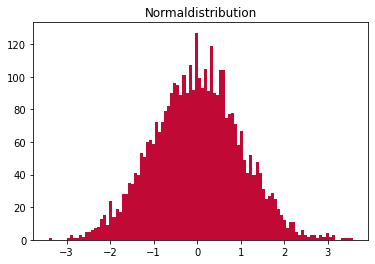

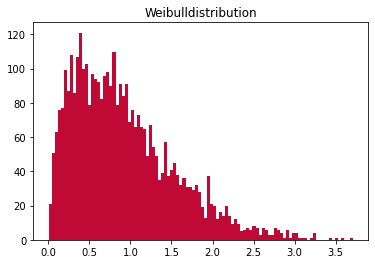

In [167]:
for name, dist in zip(distributions_names, distributions):
    ph.plot_distribution(dist[0], name)

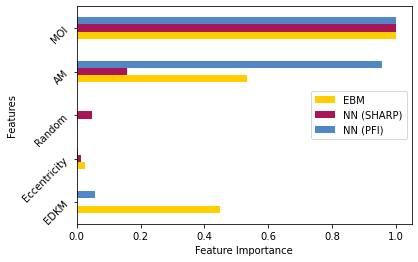

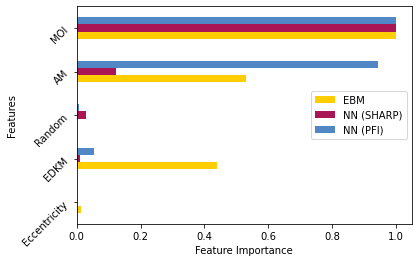

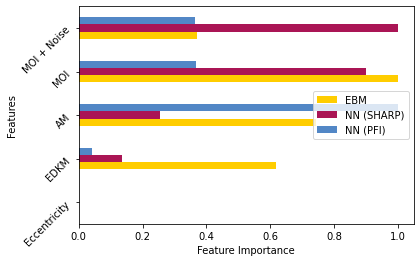

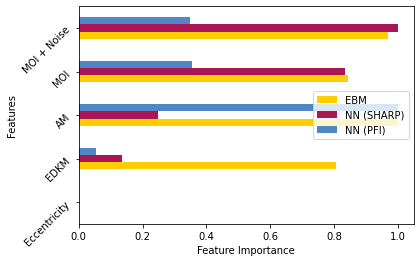

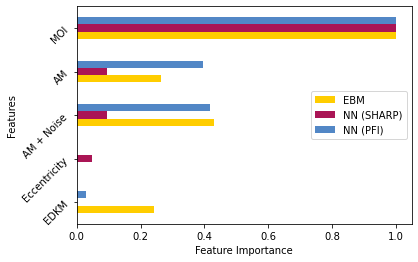

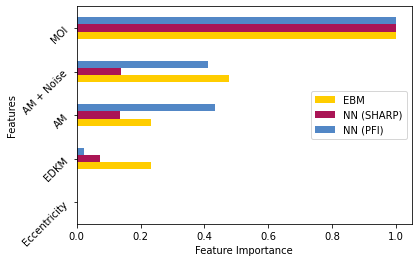

In [169]:

#fig, axs = plt.subplots(2,4)
importlib.reload(ph)
for split in split_column:
    for dist in distributions_names:
        if split == "":
            ph.plot_bar(sharp_results[f"{dist}{split}"], ebm_results[f"{dist}{split}"], pfi_results[f"{dist}{split}"], x_train.columns.tolist(), f"{dist}{split}")
        else:
            c = x_train.columns.tolist().copy()
            i = c.index('Random')
            
            columns = c[:i] + [f"{split} + Noise"] +c[i+1:]
            ph.plot_bar(sharp_results[f"{dist}{split}"], ebm_results[f"{dist}{split}"], pfi_results[f"{dist}{split}"],  columns, f"{dist}{split}")
